In [55]:
import numpy as np
import scipy.io
import xarray as xr
import os
import pandas as pd
from datetime import datetime, date, time
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
from tqdm import tqdm

from data_loading import get_altimetry_data, get_2021_CTD_data

In [4]:
ds = get_altimetry_data([2016],[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

Loading data from data/MOOSE-Altimetry/2016/01...
Loading data from data/MOOSE-Altimetry/2016/02...
Loading data from data/MOOSE-Altimetry/2016/03...
Loading data from data/MOOSE-Altimetry/2016/04...
Loading data from data/MOOSE-Altimetry/2016/05...
Loading data from data/MOOSE-Altimetry/2016/06...
Loading data from data/MOOSE-Altimetry/2016/07...
Loading data from data/MOOSE-Altimetry/2016/08...
Loading data from data/MOOSE-Altimetry/2016/09...
Loading data from data/MOOSE-Altimetry/2016/10...
Loading data from data/MOOSE-Altimetry/2016/11...
Loading data from data/MOOSE-Altimetry/2016/12...
Done!


In [12]:
ds['gos_current_norm'] = np.sqrt(ds['ugos']**2 + ds['vgos']**2)

max_current = ds['gos_current_norm'].max()
min_current = ds['gos_current_norm'].min()

ds

<xarray.Dataset>
Dimensions:           (time: 366, latitude: 128, nv: 2, longitude: 344)
Coordinates:
  * time              (time) datetime64[ns] 2016-01-20 2016-01-12 ... 2016-12-09
  * latitude          (latitude) float32 30.06 30.19 30.31 ... 45.69 45.81 45.94
  * longitude         (longitude) float32 -5.938 -5.812 -5.688 ... 36.81 36.94
  * nv                (nv) int32 0 1
Data variables:
    crs               (time) int32 -2147483647 -2147483647 ... -2147483647
    lat_bnds          (time, latitude, nv) float32 30.0 30.12 ... 45.88 46.0
    lon_bnds          (time, longitude, nv) float32 -6.0 -5.875 ... 36.88 37.0
    err               (time, latitude, longitude) float64 nan nan ... nan nan
    adt               (time, latitude, longitude) float64 nan nan ... nan nan
    ugos              (time, latitude, longitude) float64 nan nan ... nan nan
    vgos              (time, latitude, longitude) float64 nan nan ... nan nan
    sla               (time, latitude, longitude) float64 nan nan ... nan nan
    ugosa             (time, latitude, longitude) float64 nan nan ... nan nan
    vgosa             (time, latitude, longitude) float64 nan nan ... nan nan
    gos_current_norm  (time, latitude, longitude) float64 nan nan ... nan nan
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2016-01-20T00:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2016-01-20T00:00:00Z
    title:                           DT merged all satellites Mediterranean S...

/opt/anaconda3/lib/python3.12/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/lib/python3.12/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/lib/python3.12/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/lib/python3.12/site-packages/s

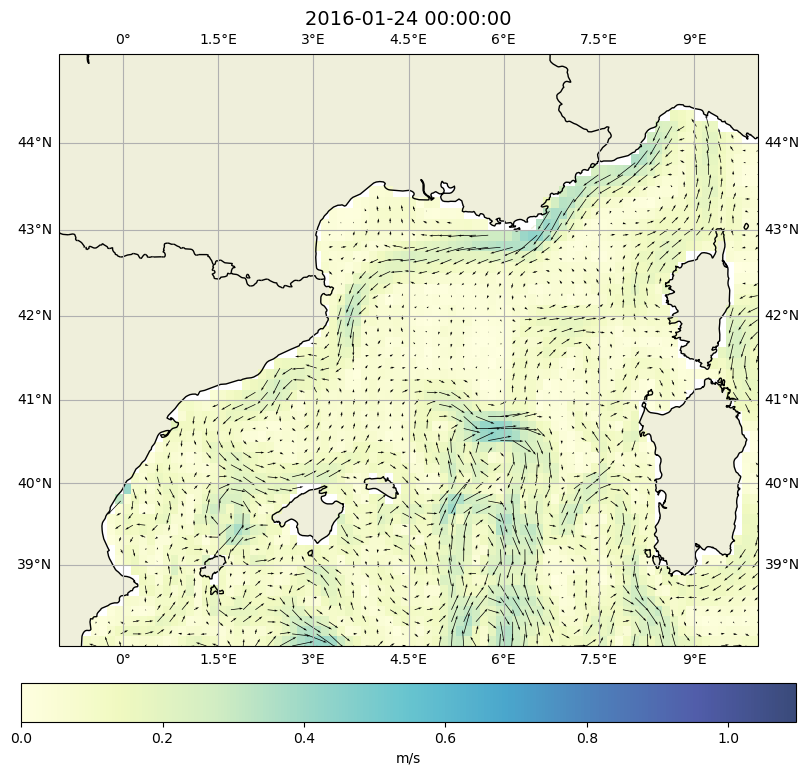

In [40]:
proj = ccrs.Mercator(central_longitude=4.5, min_latitude=38.0, max_latitude=45.0)

def plot_one_day(date):
    sub_ds = ds.sel(time=date)
    plt.figure(figsize=(10,10))
    ax = plt.axes(projection=proj)
    ax.set_extent([-1, 10, 38, 45])
    pc = ax.pcolormesh(
        sub_ds.longitude, 
        sub_ds.latitude, 
        sub_ds['gos_current_norm'], 
        transform=ccrs.PlateCarree(), 
        cmap='YlGnBu',
        alpha=0.8,
        vmax = max_current,
        vmin= min_current
    )
    #pc = ax.pcolormesh(ds_mean.longitude, ds_mean.latitude,ds_mean['ugos'], transform=ccrs.PlateCarree(), cmap='coolwarm', alpha=0.5)
    ax.quiver(
        sub_ds.longitude, 
        sub_ds.latitude, 
        sub_ds['ugos'], 
        sub_ds['vgos'], 
        transform=ccrs.PlateCarree(), 
        regrid_shape=50,
        scale=10,
        width=0.001
    )
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.gridlines(draw_labels=True)
    plt.colorbar(pc, orientation='horizontal', label='m/s', pad=0.05)
    #plt.subplots_adjust(top=0.9)
    plt.title(str(date), fontsize=14)
    plt.subplots_adjust(top=0.85)
    plt.savefig(f'film/{date}.png')

    
plot_one_day(datetime(2016, 1, 24))

In [ ]:
for day in tqdm(ds.time.values):
    plot_one_day(day)

In [53]:
import imageio
import os

filenames = [f'film/{date}.png' for date in ds.time.sortby('time').values]

In [56]:
images = []
for filename in tqdm(filenames):
    images.append(imageio.imread(filename))
imageio.mimsave('film.gif', images)

  0%|          | 0/366 [00:00<?, ?it/s]/var/folders/ks/hg8011s52v95t9b4pdt4llsm0000gn/T/ipykernel_2761/2221634686.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))
100%|██████████| 366/366 [00:03<00:00, 105.20it/s]
